<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [1]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig
from tqdm.auto import tqdm


In [2]:

from typing import Union, Dict, Any

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int = 2, dropout_rate: float = 0.1):
        super().__init__()
        
        # Инициализация базовой модели трансформера
        if isinstance(base_transformer_model, str):
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
        else:
            self.backbone = base_transformer_model
            
        # Получаем размер скрытого состояния из конфигурации модели
        hidden_size = self.backbone.config.hidden_size
        
        # Создаем дополнительные слои для классификации
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, num_classes)
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, **kwargs):
        # Получаем выходы из базовой модели трансформера
        outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            **kwargs
        )
        
        # Берем [CLS] токен (первый токен) как представление всего предложения
        # Для BERT и подобных моделей это обычно первый токен
        pooled_output = outputs.last_hidden_state[:, 0]
        
        # Применяем dropout и классификационный слой
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        # Возвращаем словарь с логитами
        return {"logits": logits}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [3]:
def freeze_backbone_function(model: TransformerClassificationModel):
    """
    Замораживает все параметры backbone части модели, чтобы они не обновлялись
    во время обучения.
    
    Args:
        model: Модель TransformerClassificationModel, у которой нужно заморозить backbone
    """
    # Устанавливаем requires_grad=False для всех параметров backbone
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    # Выводим информацию о количестве замороженных и обучаемых параметров
    frozen_params = sum(p.numel() for p in model.backbone.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Backbone заморожен.")
    print(f"Замороженные параметры: {frozen_params:,}")
    print(f"Обучаемые параметры: {trainable_params:,}")
    
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [4]:
import copy
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import numpy as np

def train_transformer(transformer_model, train_dataloader, val_dataloader, freeze_backbone=True, 
                     num_epochs=3, learning_rate=2e-5, weight_decay=0.01, 
                     warmup_steps=0, device=None):
    """
    Функция для дообучения трансформера с возможностью заморозки backbone.
    
    Args:
        transformer_model: Исходная модель TransformerClassificationModel
        train_dataloader: DataLoader для обучающей выборки
        val_dataloader: DataLoader для валидационной выборки
        freeze_backbone: Флаг, замораживать ли backbone модели
        num_epochs: Количество эпох обучения
        learning_rate: Скорость обучения
        weight_decay: Коэффициент регуляризации весов
        warmup_steps: Количество шагов для warmup
        device: Устройство для обучения (CPU/GPU)
        
    Returns:
        finetuned_model: Обученная модель
    """
    # Создаем копию модели для обучения
    model = copy.deepcopy(transformer_model)
    
    # Определяем устройство для обучения
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    
    # Замораживаем backbone, если необходимо
    if freeze_backbone:
        for param in model.backbone.parameters():
            param.requires_grad = False
        print("Backbone заморожен")
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Обучаемые параметры: {trainable_params:,} из {total_params:,} ({trainable_params/total_params:.2%})")
    else:
        print("Backbone обучается вместе с остальной моделью")
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Всего обучаемых параметров: {trainable_params:,}")
    
    # Подготавливаем оптимизатор: только обучаемые параметры
    optimizer = AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
    # Общее количество шагов обучения
    total_steps = len(train_dataloader) * num_epochs
    
    # Создаем scheduler для изменения learning rate
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Функция потерь для задачи классификации
    loss_fn = nn.CrossEntropyLoss()
    
    # Для отслеживания лучшей модели
    best_val_accuracy = 0.0
    best_model_state = None
    
    # Обучение модели
    for epoch in range(num_epochs):
        # Переключаем модель в режим обучения
        model.train()
        
        # Tracking variables
        train_loss = 0
        train_correct = 0
        train_samples = 0
        
        # Обучение на тренировочной выборке
        print(f"Эпоха {epoch+1}/{num_epochs}")
        progress_bar = tqdm(train_dataloader, desc="Обучение")
        
        for batch in progress_bar:
            # Перемещаем данные на устройство
            batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
            labels = batch.pop("labels") if "labels" in batch else batch.pop("label")
            
            # Очищаем градиенты
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(**batch)
            logits = outputs["logits"]
            
            # Вычисляем потери
            loss = loss_fn(logits, labels)
            
            # Backward pass
            loss.backward()
            
            # Обновляем веса
            optimizer.step()
            scheduler.step()
            
            # Обновляем статистику
            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == labels).sum().item()
            train_samples += labels.size(0)
            
            # Обновляем прогресс-бар
            progress_bar.set_postfix({"loss": loss.item(), 
                                     "acc": train_correct/train_samples})
        
        # Вычисляем среднюю точность и потери на тренировочной выборке
        avg_train_loss = train_loss / len(train_dataloader)
        avg_train_accuracy = train_correct / train_samples
        
        print(f"Обучение - Потери: {avg_train_loss:.4f}, Точность: {avg_train_accuracy:.4f}")
        
        # Оценка на валидационной выборке
        model.eval()
        val_loss = 0
        val_correct = 0
        val_samples = 0
        
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Валидация"):
                # Перемещаем данные на устройство
                batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
                labels = batch.pop("labels") if "labels" in batch else batch.pop("label")
                
                # Forward pass
                outputs = model(**batch)
                logits = outputs["logits"]
                
                # Вычисляем потери
                loss = loss_fn(logits, labels)
                
                # Обновляем статистику
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == labels).sum().item()
                val_samples += labels.size(0)
        
        # Вычисляем среднюю точность и потери на валидационной выборке
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_accuracy = val_correct / val_samples
        
        print(f"Валидация - Потери: {avg_val_loss:.4f}, Точность: {avg_val_accuracy:.4f}")
        
        # Сохраняем лучшую модель
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"Новая лучшая модель сохранена! Точность: {best_val_accuracy:.4f}")
    
    # Загружаем лучшие веса модели
    model.load_state_dict(best_model_state)
    print(f"Обучение завершено. Лучшая точность на валидации: {best_val_accuracy:.4f}")
    
    return model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [5]:
import re
from datasets import load_dataset
import datasets
import pandas as pd
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader


In [24]:
class MathProblemsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
        
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Токенизация текста
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long)
        }

def simple_load_data(file_path):
    try:
        df = pd.read_excel(file_path)
        print(f"Файл успешно загружен. Количество строк: {len(df)}")
    except Exception as e:
        print(f"Ошибка при загрузке файла: {e}")
        return [], []
    
    texts = []
    labels = []
    
    # Предполагаем, что первый столбец - текст задачи, второй - категория
    # Или другая структура, в зависимости от вашего файла
    if len(df.columns) >= 2:
        for _, row in df.iterrows():
            text = str(row[1])
            label = str(row[2])
            
            texts.append(text)
            labels.append(label)
    
    return texts, labels


def prepare_data_and_model(excel_file_path='data_problems.xlsx', batch_size=8, model_name='cointegrated/rubert-tiny2'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Сначала загружаем данные чтобы узнать количество классов
    texts, label_texts = simple_load_data(excel_file_path)
    unique_labels = list(set(label_texts))
    
    # Инициализируем модель с правильным количеством классов
    model_wrapper = TransformerClassificationModel(base_transformer_model=model_name,num_classes=len(unique_labels))
    
    # Создаем словарь для преобразования меток
    label_dict = {label: i for i, label in enumerate(unique_labels)}
    label_ids = [label_dict[label] for label in label_texts]
    
    # Разделение на обучающую и валидационную выборки
    train_size = int(0.8 * len(texts))
    
    train_texts = texts[:train_size]
    train_labels = label_ids[:train_size]
    
    val_texts = texts[train_size:]
    val_labels = label_ids[train_size:]
    
    # Создание датасетов
    train_dataset = MathProblemsDataset(train_texts, train_labels, tokenizer)
    val_dataset = MathProblemsDataset(val_texts, val_labels, tokenizer)
    
    # Создание загрузчиков данных
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    return model_wrapper, train_dataloader, val_dataloader

In [17]:
def simple_load_data(file_path):
    try:
        df = pd.read_excel(file_path)
        print(f"Файл успешно загружен. Количество строк: {len(df)}")
    except Exception as e:
        print(f"Ошибка при загрузке файла: {e}")
        return [], []
    
    texts = []
    labels = []
    
    # Предполагаем, что первый столбец - текст задачи, второй - категория
    # Или другая структура, в зависимости от вашего файла
    if len(df.columns) >= 2:
        for _, row in df.iterrows():
            text = str(row[1])
            label = str(row[2])
            
            texts.append(text)
            labels.append(label)
    
    return texts, labels


simple_load_data('C:\ML\deep learning shcool\data_problems_translated.xlsx')

Файл успешно загружен. Количество строк: 5273


C:\Users\user\AppData\Local\Temp\ipykernel_35820\2762846914.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = str(row[1])
C:\Users\user\AppData\Local\Temp\ipykernel_35820\2762846914.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = str(row[2])


(['To prove that the sum of the numbers of the exact square cannot be equal to 5.',
  '( b) Will the statement of the previous challenge remain true if Petia and Wasa originally planned four natural numbers?',
  'The quadratic three-member graph with the coefficients has two points with the coordinates. Show that if the distance between them is the whole number, then the fraction is parallel to the abscisse axis.',
  "Can you draw on the surface of Rubik's cube a closed path that passes through each square exactly once (the top of the square does not pass through)?",
  'Dima, who came from Vrunlandia, said that there were several lakes connected by rivers, and there were three rivers coming out of each lake, and there were four rivers in each lake, so prove him wrong.',
  'If the number is the whole, the number is the whole.',
  'Can n sit 2n + 1 round table so that no two sit next to each other more than once if (a) n = 5; (b) n = 4; (c) n is an arbitrary natural number?',
  'Natural 

In [10]:
from tqdm import tqdm

In [25]:
rubert_tiny_transformer_model = TransformerClassificationModel(base_transformer_model= 'cointegrated/rubert-tiny2')

rubert_tiny_transformer_model, train_dataloader, val_dataloader = prepare_data_and_model('C:\ML\deep learning shcool\data_problems_translated.xlsx')

rubert_tiny_finetuned_with_freezed_backbone = train_transformer(
    rubert_tiny_transformer_model, 
    train_dataloader, 
    val_dataloader, 
    freeze_backbone=True
)

Файл успешно загружен. Количество строк: 5273


C:\Users\user\AppData\Local\Temp\ipykernel_35820\1860994597.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = str(row[1])
C:\Users\user\AppData\Local\Temp\ipykernel_35820\1860994597.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = str(row[2])


Backbone заморожен
Обучаемые параметры: 2,191 из 29,195,959 (0.01%)
Эпоха 1/3


Обучение: 100%|██████████| 528/528 [02:15<00:00,  3.90it/s, loss=1.75, acc=0.344]


Обучение - Потери: 1.8138, Точность: 0.3438


Валидация: 100%|██████████| 132/132 [00:13<00:00,  9.57it/s]


Валидация - Потери: 1.7038, Точность: 0.4474
Новая лучшая модель сохранена! Точность: 0.4474
Эпоха 2/3


Обучение: 100%|██████████| 528/528 [02:25<00:00,  3.63it/s, loss=1.69, acc=0.448]


Обучение - Потери: 1.6650, Точность: 0.4481


Валидация: 100%|██████████| 132/132 [00:12<00:00, 10.97it/s]


Валидация - Потери: 1.6255, Точность: 0.4550
Новая лучшая модель сохранена! Точность: 0.4550
Эпоха 3/3


Обучение: 100%|██████████| 528/528 [02:10<00:00,  4.03it/s, loss=1.58, acc=0.457]


Обучение - Потери: 1.6148, Точность: 0.4566


Валидация: 100%|██████████| 132/132 [00:12<00:00, 10.85it/s]

Валидация - Потери: 1.6067, Точность: 0.4550
Обучение завершено. Лучшая точность на валидации: 0.4550


In [26]:
rubert_tiny_finetuned_with_no_freezed_backbone = train_transformer(
    rubert_tiny_transformer_model, 
    train_dataloader, 
    val_dataloader, 
    freeze_backbone=False
)

Backbone обучается вместе с остальной моделью
Всего обучаемых параметров: 29,195,959
Эпоха 1/3


Обучение: 100%|██████████| 528/528 [06:25<00:00,  1.37it/s, loss=1.26, acc=0.524] 


Обучение - Потери: 1.3172, Точность: 0.5237


Валидация: 100%|██████████| 132/132 [00:19<00:00,  6.64it/s]


Валидация - Потери: 1.1196, Точность: 0.5829
Новая лучшая модель сохранена! Точность: 0.5829
Эпоха 2/3


Обучение: 100%|██████████| 528/528 [04:59<00:00,  1.76it/s, loss=0.958, acc=0.607]


Обучение - Потери: 1.0704, Точность: 0.6074


Валидация: 100%|██████████| 132/132 [00:14<00:00,  8.90it/s]


Валидация - Потери: 1.0509, Точность: 0.5924
Новая лучшая модель сохранена! Точность: 0.5924
Эпоха 3/3


Обучение: 100%|██████████| 528/528 [04:58<00:00,  1.77it/s, loss=0.397, acc=0.63] 


Обучение - Потери: 0.9951, Точность: 0.6297


Валидация: 100%|██████████| 132/132 [00:18<00:00,  7.00it/s]

Валидация - Потери: 1.0309, Точность: 0.6009
Новая лучшая модель сохранена! Точность: 0.6009
Обучение завершено. Лучшая точность на валидации: 0.6009


Мы сильно повысили точность!  0.4550 vs  0.6009

In [ ]:
rubert_tiny_transformer_model = #...
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(rubert_tiny_transformer_model, freeze_backbone=True)

rubert_tiny_transformer_model = #...
rubert_tiny_full_finetuned = train_transformer(rubert_tiny_transformer_model, freeze_backbone=False)

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [28]:
### YOUR CODE IS HERE (probably, similar on the previous step)
MathBert_tbs17_transformer_model = TransformerClassificationModel(base_transformer_model= 'tbs17/MathBert')
MathBert_tbs17_transformer_model, train_dataloader, val_dataloader = prepare_data_and_model('C:\ML\deep learning shcool\data_problems_translated.xlsx')



pytorch_model.bin:  76%|#######6  | 336M/441M [00:00<?, ?B/s]

Файл успешно загружен. Количество строк: 5273


C:\Users\user\AppData\Local\Temp\ipykernel_35820\1860994597.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = str(row[1])
C:\Users\user\AppData\Local\Temp\ipykernel_35820\1860994597.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = str(row[2])


In [31]:
MathBert_tbs17_transformer_model_with_freezed_backbone = train_transformer(
    MathBert_tbs17_transformer_model, 
    train_dataloader, 
    val_dataloader, 
    freeze_backbone=True
)

Backbone заморожен
Обучаемые параметры: 2,191 из 29,195,959 (0.01%)
Эпоха 1/3


Обучение: 100%|██████████| 528/528 [02:44<00:00,  3.22it/s, loss=1.85, acc=0.31] 


Обучение - Потери: 1.8092, Точность: 0.3103


Валидация: 100%|██████████| 132/132 [00:19<00:00,  6.70it/s]


Валидация - Потери: 1.7086, Точность: 0.4398
Новая лучшая модель сохранена! Точность: 0.4398
Эпоха 2/3


Обучение: 100%|██████████| 528/528 [02:48<00:00,  3.14it/s, loss=1.28, acc=0.437]


Обучение - Потери: 1.6687, Точность: 0.4369


Валидация: 100%|██████████| 132/132 [00:18<00:00,  6.99it/s]


Валидация - Потери: 1.6301, Точность: 0.4474
Новая лучшая модель сохранена! Точность: 0.4474
Эпоха 3/3


Обучение: 100%|██████████| 528/528 [02:46<00:00,  3.17it/s, loss=2.32, acc=0.448]


Обучение - Потери: 1.6180, Точность: 0.4478


Валидация: 100%|██████████| 132/132 [00:18<00:00,  7.22it/s]

Валидация - Потери: 1.6108, Точность: 0.4531
Новая лучшая модель сохранена! Точность: 0.4531
Обучение завершено. Лучшая точность на валидации: 0.4531


In [32]:
MathBert_tbs17_transformer_model_with_no_freezed_backbone = train_transformer(
    MathBert_tbs17_transformer_model, 
    train_dataloader, 
    val_dataloader, 
    freeze_backbone=False
)

Backbone обучается вместе с остальной моделью
Всего обучаемых параметров: 29,195,959
Эпоха 1/3


Обучение: 100%|██████████| 528/528 [06:12<00:00,  1.42it/s, loss=0.639, acc=0.52] 


Обучение - Потери: 1.3300, Точность: 0.5204


Валидация: 100%|██████████| 132/132 [00:13<00:00,  9.97it/s]


Валидация - Потери: 1.1255, Точность: 0.5725
Новая лучшая модель сохранена! Точность: 0.5725
Эпоха 2/3


Обучение: 100%|██████████| 528/528 [06:43<00:00,  1.31it/s, loss=0.133, acc=0.602]


Обучение - Потери: 1.0590, Точность: 0.6022


Валидация: 100%|██████████| 132/132 [00:21<00:00,  6.04it/s]


Валидация - Потери: 1.0494, Точность: 0.5962
Новая лучшая модель сохранена! Точность: 0.5962
Эпоха 3/3


Обучение: 100%|██████████| 528/528 [06:58<00:00,  1.26it/s, loss=1.67, acc=0.627] 


Обучение - Потери: 0.9902, Точность: 0.6271


Валидация: 100%|██████████| 132/132 [00:19<00:00,  6.71it/s]

Валидация - Потери: 1.0327, Точность: 0.5896
Обучение завершено. Лучшая точность на валидации: 0.5962


### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [ ]:
def draw_first_layer_attention_maps(attention_head_ids: List, text: str, model: TransformerClassificationModel):
    pass

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from typing import List

def draw_first_layer_attention_maps(
    attention_head_ids: List[int], 
    text: str,
    model: TransformerClassificationModel,
    max_display_tokens: int = 30
):
    """
    Визуализирует карты внимания указанных голов первого слоя
    
    Параметры:
        attention_head_ids: список индексов голов внимания для визуализации
        text: входной текст для анализа
        model: модель классификации
        max_display_tokens: максимальное количество отображаемых токенов
    """
    # Проверка доступности вниманий в модели
    if not hasattr(model.backbone.config, 'output_attentions') or not model.backbone.config.output_attentions:
        raise ValueError("Model must be initialized with output_attentions=True")
    
    # Определение устройства
    device = next(model.parameters()).device
    
    # Токенизация текста
    tokenizer = AutoTokenizer.from_pretrained(model.backbone.config.name_or_path)
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    ).to(device)
    
    # Получение вниманий
    with torch.no_grad():
        outputs = model.backbone(**inputs, output_attentions=True)
    
    # Извлечение первого слоя
    first_layer_attentions = outputs.attentions[0]  # [1, num_heads, seq_len, seq_len]
    num_heads = first_layer_attentions.shape[1]
    
    # Валидация индексов голов
    for head_id in attention_head_ids:
        if head_id >= num_heads:
            raise ValueError(f"Head ID {head_id} out of range (total heads: {num_heads})")
    
    # Создание субплотов
    num_plots = len(attention_head_ids)
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 5))
    
    # Обработка каждого выбранного внимания
    for i, head_id in enumerate(attention_head_ids):
        # Получение матрицы внимания для конкретной головы
        attention = first_layer_attentions[0, head_id].cpu().numpy()
        
        # Обрезка по реальной длине
        actual_len = inputs['attention_mask'].sum().item()
        attention = attention[:actual_len, :actual_len]
        tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])[:actual_len]
        
        # Ограничение отображаемых токенов
        if len(tokens) > max_display_tokens:
            tokens = tokens[:max_display_tokens]
            attention = attention[:max_display_tokens, :max_display_tokens]
        
        # Визуализация
        ax = axes[i] if num_plots > 1 else axes
        im = ax.imshow(attention, cmap='viridis')
        ax.set_title(f"Head {head_id}", fontsize=12)
        ax.set_xticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=90, fontsize=8)
        ax.set_yticks(range(len(tokens)))
        ax.set_yticklabels(tokens, fontsize=8)
        
        if i == 0:
            ax.set_ylabel("Source Tokens")
        ax.set_xlabel("Target Tokens")
    
    plt.colorbar(im, ax=axes.ravel().tolist())
    plt.tight_layout()
    plt.show()

# Пример использования:
# draw_first_layer_attention_maps(
#     attention_head_ids=[3, 5],
#     text="Решите уравнение: x^2 + 5x + 6 = 0",
#     model=your_model_instance
# )

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

AttributeError: 'Axes' object has no attribute 'ravel'

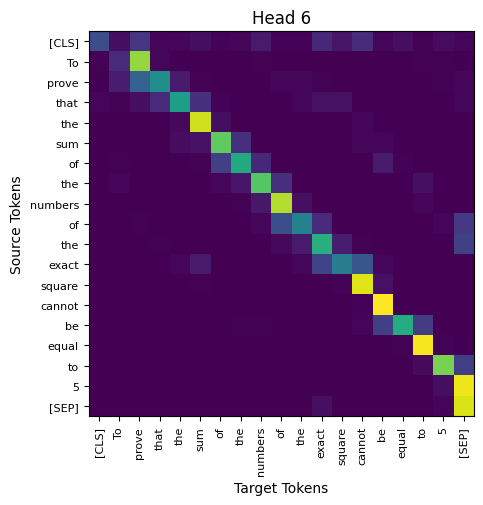

In [47]:
rubert_tiny_transformer_model.backbone.config.output_attentions = True
draw_first_layer_attention_maps(
   attention_head_ids=[6],
text="To prove that the sum of the numbers of the exact square cannot be equal to 5",
  model=rubert_tiny_transformer_model )

In [ ]:
### YOUR CODE IS HERE

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

AttributeError: 'Axes' object has no attribute 'ravel'

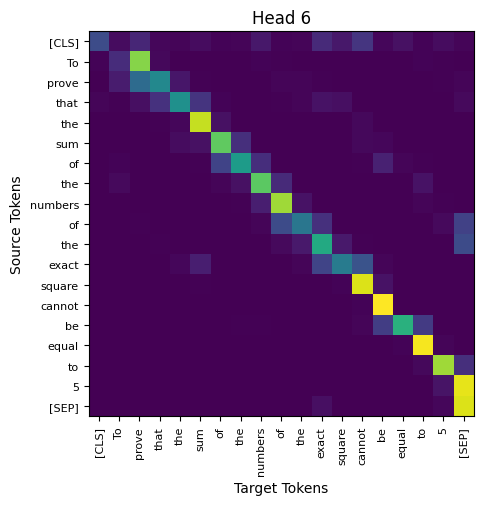

In [46]:
MathBert_tbs17_transformer_model_with_no_freezed_backbone.backbone.config.output_attentions = True
draw_first_layer_attention_maps(
   attention_head_ids=[6],
text="To prove that the sum of the numbers of the exact square cannot be equal to 5",
  model=MathBert_tbs17_transformer_model_with_no_freezed_backbone )